# Example notebook to read and plot ERA5 output

This notebook reads and plots monthly averaged, reanalyis surface temperature for the Southern Ocean region in 2019. Data was sourced from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview. The Southern Ocean is taken to be area bounded by $55^{\circ}-65^{\circ}$S. Data were selected for all months in 2019 and saved as netCDF. This data subset is roughly 2 MB. 

I would recommend getting the Anaconda distribution: https://www.anaconda.com/distribution/. The Anaconda distribution comes with most of the numerical and scientific modules pre-installed. It also supports jupyter notebooks (such as this one). You may also need to download additional modules like xarray and cartopy (see instructions at the end).

In [15]:
# import necessary python modules
import numpy as np # for numerical calculations
import matplotlib.pylab as plt # for plotting
import xarray as xr # for numerical calculations and reading netCDF data
import os  # general purpose module for interacting with your operating system 
from datetime import datetime # to handle datetime objects
import pandas as pd
import cartopy.crs as ccrs # for mapping
import cartopy.feature # for mapping
import calendar as cal

data_dir = '../data/ERA5/monthly/'
fz = 14 # define fontsize

Let's take a look at the data using xarray...

In [4]:
fname = 'sst_2019_50S-65S.nc'
fpath = os.path.join(data_dir, fname)
ds = xr.open_dataset(fpath)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 61, longitude: 1440, time: 12)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 -50.0 -50.25 -50.5 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-27 19:27:07 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


The variable `ds` is an *xarray dataset*, which is a container variable for storing data. An xarray dataset is similar to a python dictionary or matlab struct, but has the added benefit of carrying information about the data that it holds (i.e. metadata). xarray is also useful for reading and writing netCDF data. 

The command `print(ds)` provides a summary of the file's metadata. We see that the dataset contains one variable `sst`, which has three dimensions: `latitude`, `longitude`, and `time`.

In [5]:
print(ds['sst'])

<xarray.DataArray 'sst' (time: 12, latitude: 61, longitude: 1440)>
[1054080 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 -50.0 -50.25 -50.5 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Attributes:
    units:      K
    long_name:  Sea surface temperature


Taking a closer look at the `sst` variable, we see that it is in fact sea surface temperature and has units of Kelvins, which we may want to change to Celsius. 

Next, we take a spatial average and plot the result as a time series. 

In [20]:
ds_xymean = ds.mean(dim=['latitude', 'longitude'])
print(ds_xymean)

<xarray.Dataset>
Dimensions:  (time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    sst      (time) float32 276.4809 276.94443 276.82547 ... 275.00952 276.01135


Text(0.5, 1.0, 'Mean SST for the Southern Ocean')

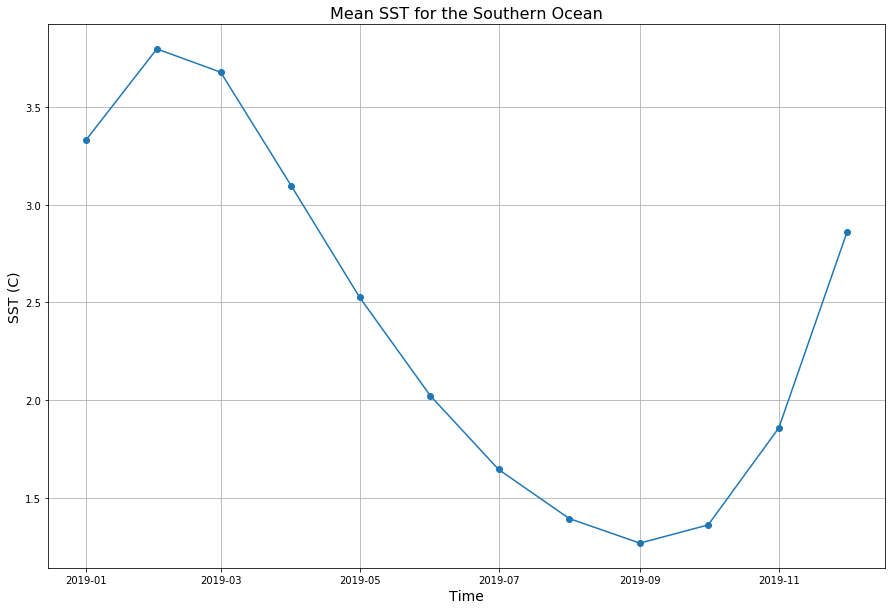

In [23]:
sstC_xymean = ds_xymean['sst'] -273.15 # convert to Celsius
plt.figure(figsize=(15, 10)) # default figsize is kinda small
plt.plot(ds_xymean['time'], sstC_xymean, '-o') 
plt.grid(True)
plt.ylabel("SST (C)", fontsize=fz)
plt.xlabel("Time", fontsize=fz)
plt.title("Mean SST for the Southern Ocean", fontsize=fz+2)
#plt.axhline(950, linestyle='--', color='r') # add storm threshold used by Campbell et al. (2019)

This plot shows monthly estimates of SST for 2019. There are lots we can do enhance the visuals of this plots, but this fine for now. 

Next we plot the spatial pattern of the monthly data. First, let's just plot the data for one month.

Text(0, 0.5, 'SST ($^{\\circ}$C)')

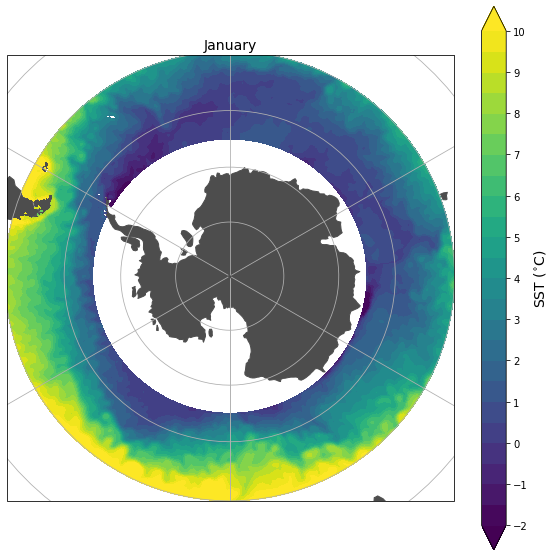

In [41]:
# adapted from https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html
sstC = ds['sst'] - 273.13
fig = plt.figure(figsize=[10, 10])
clvls = np.arange(-2, 10.1, 0.5)
mon = 1 # i.e. the first month (note that python uses a zero-based index)

ax = plt.axes(projection=ccrs.SouthPolarStereo())
 
# Limit the map to -50 degrees latitude and below.
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, color='0.3') # '0.3' is a shade of gray; '0' is black, '1' is white.
ax.gridlines()

im = ax.contourf(ds['longitude'], ds['latitude'], sstC[mon-1, :, :], clvls, vmin=clvls[0], vmax=clvls[-1], 
                   cmap=plt.cm.viridis, extend='both', transform=ccrs.PlateCarree())
ax.set_title("%s" %cal.month_name[mon], fontsize=14)
    
cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_ticks(clvls[::2])
cbar.ax.set_ylabel("SST ($^{\circ}$C)", fontsize=14)

Next, we loop through the data and plot four different months

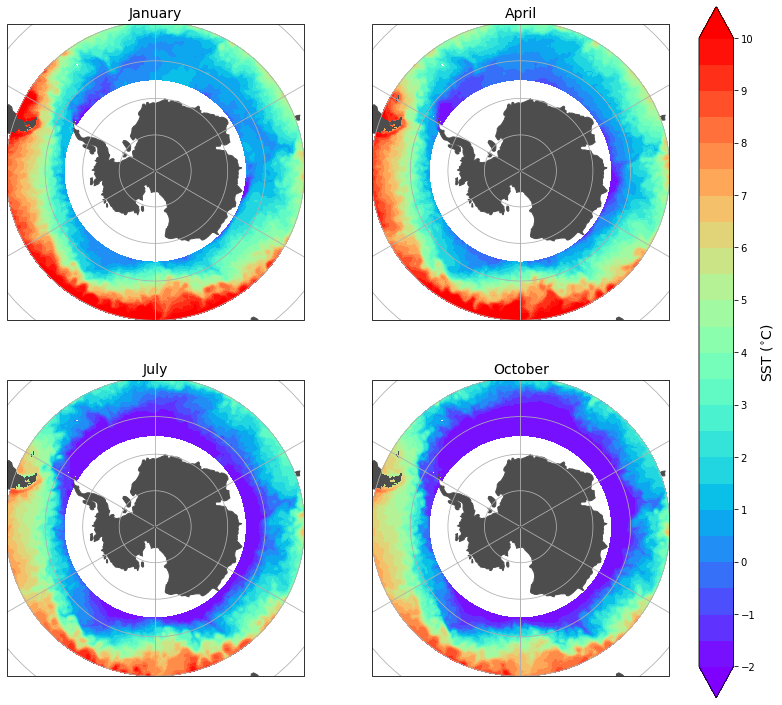

In [44]:
sstC = ds['sst'] - 273.13

fig = plt.figure(figsize=[12, 12])
mons = [1, 4, 7, 10]
clvls = np.arange(-2, 10.1, 0.5)

for m,mon in enumerate(mons):
    
    ax = plt.subplot(2, 2, m+1, projection=ccrs.SouthPolarStereo()) # you can try different projections
    
    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

    ax.add_feature(cartopy.feature.LAND, color='0.3')

    ax.gridlines()
    
    im = ax.contourf(ds['longitude'], ds['latitude'], sstC[mon-1, :, :], clvls, vmin=clvls[0], vmax=clvls[-1], 
                       cmap=plt.cm.rainbow, extend='both', transform=ccrs.PlateCarree())
    ax.set_title("%s" %cal.month_name[mon], fontsize=14)
    
cb_ax = fig.add_axes([0.93, 0.1, 0.04, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, extend='both')
cbar.set_ticks(clvls[::2])
cbar.ax.set_ylabel("SST ($^{\circ}$C)", fontsize=14)
plt.show()

check out: https://matplotlib.org/tutorials/colors/colormaps.html for more colormap options.

## To-do list for this week: 

+ Download and install Python from Anaconda (https://www.anaconda.com/distribution/). 
    + Also, visit the [Jupyter Notebook docs](https://jupyter-notebook.readthedocs.io/en/stable/) to learn how to read and create Notebooks like this one. 
    
    
+ Install xarray and quickly skim through the getting started page: http://xarray.pydata.org/en/stable/.


+ Download and install cartopy: https://scitools.org.uk/cartopy/docs/v0.13/index.html. (this can be finnicky so let me know if you have any issues).


+ Once you manage to get this Notebook running on your own, visit the ERA5 page to download additional data for the Southern Ocean. You will need to create an account to download the data. Since each each year is only 2MB, it shouldn't be too cumbersome to download all the data since 2005. If this is too much you can just get the past 5 years.


+ In addition to SST, try downloading and plotting the mean surface heat fluxes (sensible, latent, net longwave, and net solar radition), and eastward turbulent surface stress. These will be used in our heat budget analysis. Be sure to read the variable description on the ERA5 site: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview